TUBES DKA

Anggota Kelompok : 
1. Falah Razan Hibrizi
2. Fazari Razka Davira
3. Irham Kurnia Putra

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.metrics import accuracy_score, f1_score

In [133]:
df = pd.read_csv("df_selected_heart_attack.csv")
df.head(10)

,Age,Troponin,Risk
0,64,0.012,0
1,21,1.060,1
2,55,0.003,0
3,64,0.122,1
4,55,0.003,0
5,58,0.004,0
6,32,0.003,0
7,63,2.370,1
8,44,0.004,0
9,67,0.011,0


Fuzzification

In [134]:
def fuzzy_age(value):
    hasil = {"Rendah": 0, "Normal": 0, "Tinggi": 0}
    a, b, c, d = 20, 35, 55, 75
    if value <= a:
        hasil["Rendah"] = 1
    elif a < value < b:
        hasil["Rendah"] = (b - value) / (b - a)
    if a < value < b:
        hasil["Normal"] = (value - a) / (b - a)
    elif b <= value <= c:
        hasil["Normal"] = 1
    elif c < value < d:
        hasil["Normal"] = (d - value) / (d - c)
    if value >= d:
        hasil["Tinggi"] = 1
    elif c < value < d:
        hasil["Tinggi"] = (value - c) / (d - c)
    return hasil

In [135]:
def fuzzy_troponin(value):
    hasil = {"Rendah": 0, "Normal": 0, "Tinggi": 0}
    a, b, c, d = 0, 0.05, 0.4, 0.8
    if value <= a:
        hasil["Rendah"] = 1
    elif a < value < b:
        hasil["Rendah"] = (b - value) / (b - a)
    if a < value < b:
        hasil["Normal"] = (value - a) / (b - a)
    elif b <= value <= c:
        hasil["Normal"] = 1
    elif c < value < d:
        hasil["Normal"] = (d - value) / (d - c)
    if value >= d:
        hasil["Tinggi"] = 1
    elif c < value < d:
        hasil["Tinggi"] = (value - c) / (d - c)
    return hasil

Sugeno System

In [136]:
def sugeno_infer(age, troponin):
    rules = {
        ('Rendah', 'Rendah'): 0.1,
        ('Rendah', 'Normal'): 0.2,
        ('Rendah', 'Tinggi'): 0.5,
        ('Normal', 'Rendah'): 0.3,
        ('Normal', 'Normal'): 0.5,
        ('Normal', 'Tinggi'): 0.7,
        ('Tinggi', 'Rendah'): 0.6,
        ('Tinggi', 'Normal'): 0.8,
        ('Tinggi', 'Tinggi'): 1.0,
    }
    fuzzy_age_val = fuzzy_age(age)
    fuzzy_trop_val = fuzzy_troponin(troponin)
    weighted_sum, total_weight = 0, 0
    for a_cat, a_val in fuzzy_age_val.items():
        for t_cat, t_val in fuzzy_trop_val.items():
            fire = min(a_val, t_val)
            out = rules.get((a_cat, t_cat), 0)
            weighted_sum += fire * out
            total_weight += fire
    return weighted_sum / total_weight if total_weight > 0 else 0

In [137]:
df['sugeno_score'] = df.apply(lambda row: sugeno_infer(row['Age'], row['Troponin']), axis=1)
df['sugeno_pred'] = df['sugeno_score'].apply(lambda x: 1 if x >= 0.5 else 0)

In [138]:
acc = accuracy_score(df['Risk'], df['sugeno_pred'])
f1 = f1_score(df['Risk'], df['sugeno_pred'])

print("Akurasi:", round(acc * 100, 2), "%")
print("F1-Score:", round(f1, 2))

Akurasi: 75.13 %
F1-Score: 0.78


Mamdani Method

In [139]:
age = ctrl.Antecedent(np.arange(0, 101, 1), 'age')
troponin = ctrl.Antecedent(np.arange(0, 1.1, 0.01), 'troponin')
risk = ctrl.Consequent(np.arange(0, 101, 1), 'risk')

age['rendah'] = fuzz.trimf(age.universe, [0, 15, 30])
age['normal'] = fuzz.trimf(age.universe, [25, 45, 65])
age['tinggi'] = fuzz.trimf(age.universe, [60, 75, 100])

troponin['rendah'] = fuzz.trimf(troponin.universe, [0, 0.03, 0.1])
troponin['normal'] = fuzz.trimf(troponin.universe, [0.08, 0.3, 0.6])
troponin['tinggi'] = fuzz.trimf(troponin.universe, [0.5, 0.75, 1.0])

risk['rendah'] = fuzz.trimf(risk.universe, [0, 15, 30])
risk['sedang'] = fuzz.trimf(risk.universe, [25, 50, 75])
risk['tinggi'] = fuzz.trimf(risk.universe, [70, 85, 100])

In [140]:
rules = [
    ctrl.Rule(age['tinggi'] & troponin['tinggi'], risk['tinggi']),
    ctrl.Rule(age['tinggi'] & troponin['normal'], risk['tinggi']),
    ctrl.Rule(age['normal'] & troponin['tinggi'], risk['tinggi']),
    ctrl.Rule(age['normal'] & troponin['normal'], risk['sedang']),
    ctrl.Rule(age['rendah'] & troponin['tinggi'], risk['sedang']),
    ctrl.Rule(age['tinggi'] & troponin['rendah'], risk['sedang']),
    ctrl.Rule(age['normal'] & troponin['rendah'], risk['rendah']),
    ctrl.Rule(age['rendah'] & troponin['normal'], risk['rendah']),
    ctrl.Rule(age['rendah'] & troponin['rendah'], risk['rendah']),
]

In [141]:
risk_ctrl = ctrl.ControlSystem(rules)
risk_sim = ctrl.ControlSystemSimulation(risk_ctrl)

In [142]:
mamdani_scores = []
for _, row in df.iterrows():
    try:
        risk_sim.input['age'] = row['Age']
        risk_sim.input['troponin'] = row['Troponin']
        risk_sim.compute()
        mamdani_scores.append(risk_sim.output['risk'])
    except:
        mamdani_scores.append(0)
    risk_sim.reset()

In [143]:
df['mamdani_score'] = mamdani_scores
df['mamdani_pred'] = df['mamdani_score'].apply(lambda x: 1 if x >= 50 else 0)

In [144]:
acc_mamdani = accuracy_score(df['Risk'], df['mamdani_pred'])
f1_mamdani = f1_score(df['Risk'], df['mamdani_pred'])

print("Akurasi Mamdani:", round(acc_mamdani * 100, 2), "%")
print("F1-Score Mamdani:", round(f1_mamdani, 2))

Akurasi Mamdani: 54.81 %
F1-Score Mamdani: 0.44


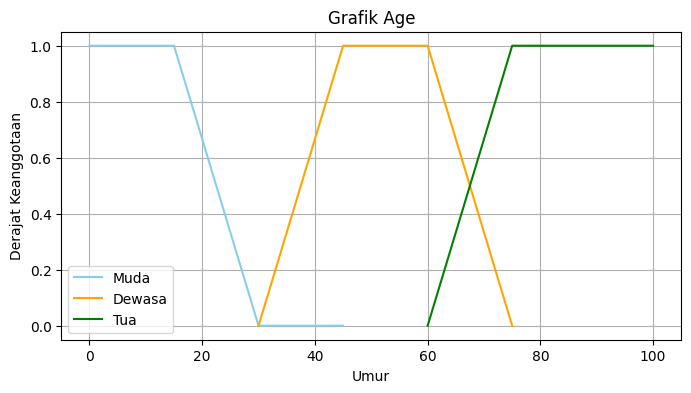

In [145]:
x_muda = [0, 15, 30, 45]
y_muda = [1, 1, 0, 0]

x_dewasa = [30, 45, 60, 75]
y_dewasa = [0, 1, 1, 0]

x_tua = [60, 75, 90, 100]
y_tua = [0, 1, 1, 1]

plt.figure(figsize=(8, 4))
plt.plot(x_muda, y_muda, label="Muda", color="skyblue")
plt.plot(x_dewasa, y_dewasa, label="Dewasa", color="orange")
plt.plot(x_tua, y_tua, label="Tua", color="green")

plt.title("Grafik Age")
plt.xlabel("Umur")
plt.ylabel("Derajat Keanggotaan")
plt.legend()
plt.grid(True)
plt.show()

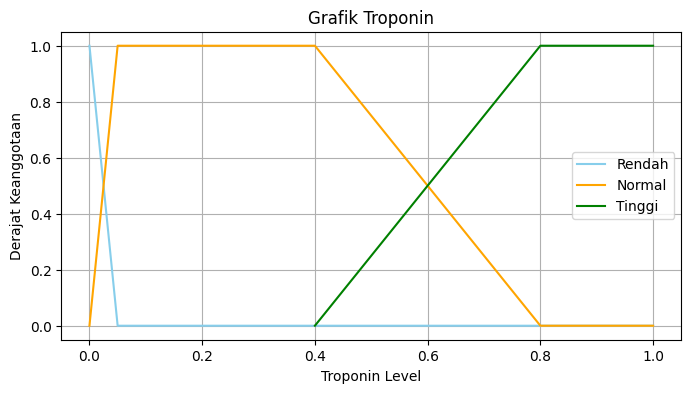

In [146]:
x_rendah = [0.0, 0.0, 0.05, 1.0]
y_rendah = [1, 1, 0, 0]

x_normal = [0.0, 0.05, 0.4, 0.8, 1.0]
y_normal = [0, 1, 1, 0, 0]

x_tinggi = [0.4, 0.8, 1.0]
y_tinggi = [0, 1, 1]

plt.figure(figsize=(8, 4))
plt.plot(x_rendah, y_rendah, label="Rendah", color="skyblue")
plt.plot(x_normal, y_normal, label="Normal", color="orange")
plt.plot(x_tinggi, y_tinggi, label="Tinggi", color="green")

plt.title("Grafik Troponin")
plt.xlabel("Troponin Level")
plt.ylabel("Derajat Keanggotaan")
plt.legend()
plt.grid(True)
plt.show()

Defuzzification

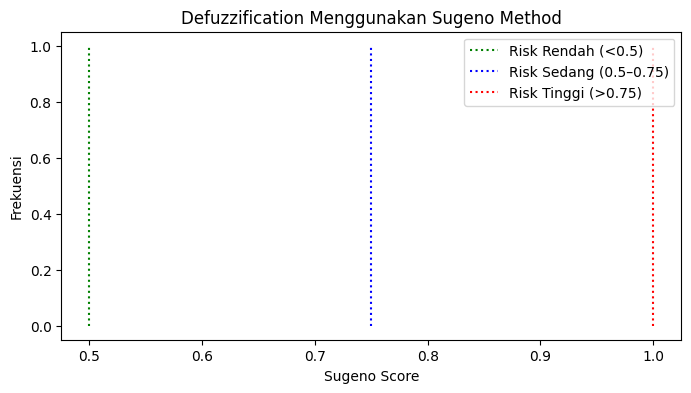

In [149]:


plt.figure(figsize=(8, 4))
plt.title("Defuzzification Menggunakan Sugeno Method")
plt.vlines(0.5, 0, 1, linestyles="dotted", colors="green", label="Risk Rendah (<0.5)")
plt.vlines(0.75, 0, 1, linestyles="dotted", colors="blue", label="Risk Sedang (0.5–0.75)")
plt.vlines(1.0, 0, 1, linestyles="dotted", colors="red", label="Risk Tinggi (>0.75)")
plt.xlabel("Sugeno Score")
plt.ylabel("Frekuensi")
plt.legend()
plt.show()
